In [2]:
import gzip
import gensim 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from torchtext import data
from torchtext import datasets
import collections
import math

In [4]:
import re
import spacy

nlp = spacy.load('en')
MAX_CHARS = 20000
def tokenizer(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|;]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", "!", comment)
    comment = re.sub(r"\,+", ",", comment)
    comment = re.sub(r"\?+", "?", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [x.text for x in nlp.tokenizer(comment) if x.text != " "]

In [5]:
TEXT = data.Field(tokenize=tokenizer)
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = data.TabularDataset.splits(path='./', format='csv',train='train.csv', test='test.csv', fields=[('text', TEXT), ('label', LABEL)])

In [6]:
train_data, valid_data = train_data.split()

In [7]:
embedding = torchtext.vocab.Vectors('quora.300d.txt')

TEXT.build_vocab(train_data, 
                 vectors = embedding,
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

100%|█████████▉| 87492/87708 [00:09<00:00, 9089.82it/s]


In [8]:
BATCH_SIZE = 2048

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False)

In [9]:
device

device(type='cuda')

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.apply(init_weights)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        logits = self.fc(cat)
        
        return logits

In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def metrics(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    acc = accuracy_score(y.cpu(), rounded_preds.detach().cpu())
    f1 = f1_score(y.cpu(), rounded_preds.detach().cpu())
    return acc, f1

In [13]:
def train_cnn(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, f1 = metrics(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [14]:
def evaluate_cnn(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc, f1 = metrics(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [15]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

cnn = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors

cnn.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

cnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
cnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [16]:
import torch.optim as optim

optimizer = optim.Adam(cnn.parameters())

criterion = nn.BCEWithLogitsLoss()

cnn = cnn.to(device)
criterion = criterion.to(device)

In [17]:
N_EPOCHS = 10

best_valid_f1 = 0

for epoch in range(N_EPOCHS):
    
    train_loss, train_acc, train_f1 = train_cnn(cnn, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate_cnn(cnn, valid_iterator, criterion)
    
    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(cnn.state_dict(), 'CNN-model.pt')
    
    print('Epoch:',epoch+1)
    print('Train Loss:',train_loss)
    print('Train Acc:',train_acc*100)
    print('Train F1:',train_f1*100)
    print('Val. Loss:',valid_loss) 
    print('Val. Acc:',valid_acc*100)
    print('Val. F1:',valid_f1*100)

Epoch: 1
Train Loss: 0.5215374873744116
Train Acc: 80.81981529096342
Train F1: 80.24918628346424
Val. Loss: 0.3276472923002745
Val. Acc: 86.7142269736842
Val. F1: 86.6750304316254
Epoch: 2
Train Loss: 0.32958678868081837
Train Acc: 86.5363978990858
Train F1: 86.34923935379986
Val. Loss: 0.3046166802707471
Val. Acc: 87.8374954609535
Val. F1: 87.85769656696722
Epoch: 3
Train Loss: 0.29064428077803717
Train Acc: 88.36043534634317
Train F1: 88.21915630867922
Val. Loss: 0.2957456127593392
Val. Acc: 88.23539495044429
Val. F1: 88.16649215416878
Epoch: 4
Train Loss: 0.2650178482135137
Train Acc: 89.53419754307315
Train F1: 89.40856913760705
Val. Loss: 0.28961811881316335
Val. Acc: 88.69447945146959
Val. F1: 88.58763090390471
Epoch: 5
Train Loss: 0.24404809772968292
Train Acc: 90.47760636427567
Train F1: 90.37452208696944
Val. Loss: 0.2839358809747194
Val. Acc: 88.848345117054
Val. F1: 88.9293453060961
Epoch: 6
Train Loss: 0.22673902842733595
Train Acc: 91.24186060566105
Train F1: 91.1571758878

In [18]:
def predict(model, sentence, min_len = 5):
    model.eval()
    if len(sentence) < min_len:
        sentence += ['<pad>'] * (min_len - len(sentence))
    indexed = [TEXT.vocab.stoi[t] for t in sentence]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor)).item()
    if prediction >= 0.5:
        idx = 1
    else:
        idx = 0
    return idx

In [19]:
torch.cuda.empty_cache()
cnn.load_state_dict(torch.load('CNN-model.pt'))
correct = 0
total = 0
preds = []
labels = []
for e in test_data.examples:
    pred = predict(cnn, e.text)
    preds.append(pred)
    labels.append(LABEL.vocab.stoi[e.label])
    if LABEL.vocab.stoi[e.label] == pred:
        correct += 1
    total += 1
    
f1 = f1_score(labels, preds, average='weighted')
print(correct/total)
print(f1)

0.8907004083653013
0.8906959610776845


In [23]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [24]:
from sklearn.metrics import plot_confusion_matrix

In [26]:
import matplotlib.pyplot as plt

In [35]:
import numpy as np

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

In [38]:
cnf_matrix = confusion_matrix(labels, preds, labels=[0, 1])

Confusion matrix, without normalization
[[14451  1575]
 [ 1958 14340]]


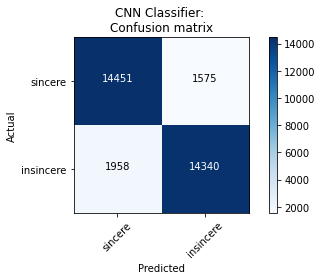

In [39]:

plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['sincere', 'insincere'], 
                      title='CNN Classifier: \nConfusion matrix')

In [40]:
from sklearn.metrics import classification_report as clsr
print(clsr(labels, preds, target_names=['sincere', 'insincere']))

              precision    recall  f1-score   support

     sincere       0.88      0.90      0.89     16026
   insincere       0.90      0.88      0.89     16298

    accuracy                           0.89     32324
   macro avg       0.89      0.89      0.89     32324
weighted avg       0.89      0.89      0.89     32324



In [20]:
def predict_class(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = []
    for t in tokenized:
        if t in TEXT.vocab.stoi:
            indexed.append(TEXT.vocab.stoi[t])
        else:
            indexed.append(0)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor)).item()
    if prediction >= 0.5:
        idx = 1
    else:
        idx = 0
    label = LABEL.vocab.itos[1]
    if label == '1':
        return "{0}%".format(prediction*100)
    else:
        return "{0}%".format((1-prediction)*100)

In [21]:
predict_class(cnn, "What?")

'4.906708002090454%'

In [22]:
"""cpu = torch.device('cpu')
model_cpu = model.to(cpu)
torch.save(model_cpu.state_dict(), 'CNN-model-cpu.pt')"""

"cpu = torch.device('cpu')\nmodel_cpu = model.to(cpu)\ntorch.save(model_cpu.state_dict(), 'CNN-model-cpu.pt')"